In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap
import cftime as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from numpy import inf

In [2]:
disc_pred = np.load('/user/home/al18709/work/gan_predictions_20/validation_disc_pred-opt_modular_part2_raw.npy')
inputs = np.load('/user/work/al18709/tc_data_flipped/KE_tracks/valid_X.npy')

In [3]:
print(disc_pred.shape)
print(inputs.shape)

(15930, 1, 20)
(15930, 6)


In [4]:
print(disc_pred[10,0,2])

8.022035598754883


/tmp/ipykernel_221128/2021203715.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(disc_pred[:,0,0], shade=True, color="blue")


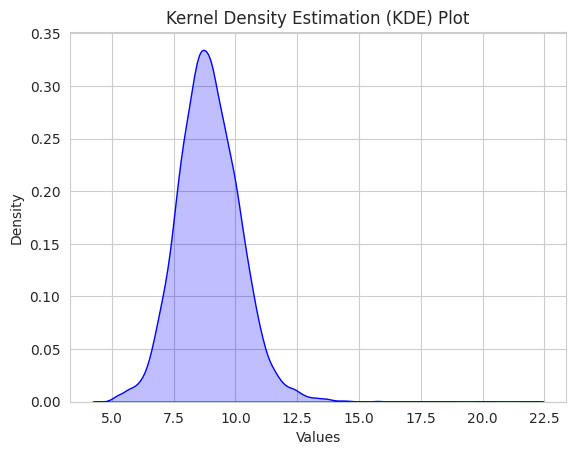

In [5]:
sns.set_style("whitegrid")  # You can change the style to your preference
sns.kdeplot(disc_pred[:,0,0], shade=True, color="blue")
plt.title("Kernel Density Estimation (KDE) Plot")
plt.xlabel("Values")
plt.ylabel("Density")
plt.show()

In [15]:
percentiles = np.arange(0,100,10)
pred_p = np.percentile(disc_pred[:,0,0], percentiles)
min = np.min(disc_pred[:,0,0])
max = np.max(disc_pred[:,0,0])
limits = [0] * 10
limits[-1] = max
limits[0:-1] = pred_p

In [16]:
print(pred_p)
print(limits)

[ 4.77684593  7.39555321  7.89086885  8.25638504  8.56099586  8.85766268
  9.16463242  9.51134958  9.93210278 10.49273853]
[4.776845932006836, 7.395553207397461, 7.890868854522705, 8.256385040283202, 8.560995864868165, 8.857662677764893, 9.164632415771484, 9.51134958267212, 9.93210277557373, 10.49273853302002, 21.905651092529297]


In [17]:

p_10 = inputs[(disc_pred[:,0,0] > limits[0]) & (disc_pred[:,0,0] < limits[1]),:]
p_20 = inputs[(disc_pred[:,0,0] > limits[1]) & (disc_pred[:,0,0] < limits[2]),:]
p_30 = inputs[(disc_pred[:,0,0] > limits[2]) & (disc_pred[:,0,0] < limits[3]),:]
p_40 = inputs[(disc_pred[:,0,0] > limits[3]) & (disc_pred[:,0,0] < limits[4]),:]
p_50 = inputs[(disc_pred[:,0,0] > limits[4]) & (disc_pred[:,0,0] < limits[5]),:]
p_60 = inputs[(disc_pred[:,0,0] > limits[5]) & (disc_pred[:,0,0] < limits[6]),:]
p_70 = inputs[(disc_pred[:,0,0] > limits[6]) & (disc_pred[:,0,0] < limits[7]),:]
p_80 = inputs[(disc_pred[:,0,0] > limits[7]) & (disc_pred[:,0,0] < limits[8]),:]
p_90 = inputs[(disc_pred[:,0,0] > limits[8]) & (disc_pred[:,0,0] < limits[9]),:]
p_100 = inputs[(disc_pred[:,0,0] > limits[9]) & (disc_pred[:,0,0] < limits[10]),:]


In [18]:
print(p_10.shape)
print(p_100.shape)

(1592, 6)
(1592, 6)


/tmp/ipykernel_221128/2330023119.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(p_10[:,i], shade=True, color="#A8CCE3", ax=axes[row,col])
/tmp/ipykernel_221128/2330023119.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(p_20[:,i], shade=True, color="#98B5D9", ax=axes[row,col])
/tmp/ipykernel_221128/2330023119.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(p_30[:,i], shade=True, color="#89A0CF", ax=axes[row,col])
/tmp/ipykernel_221128/2330023119.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  s

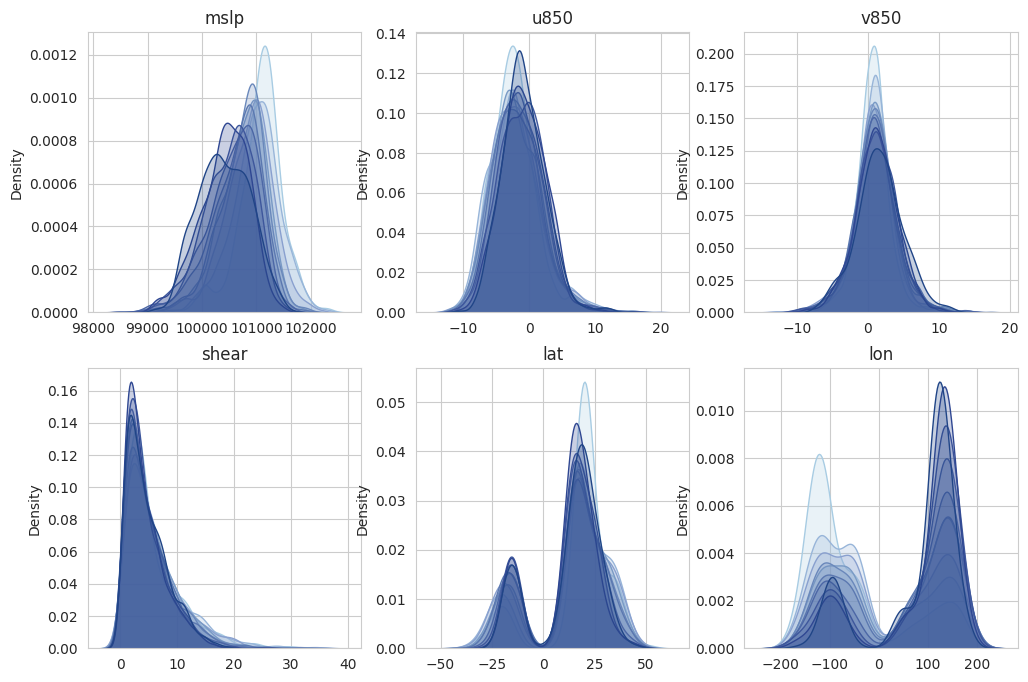

In [29]:
sns.set_style("whitegrid")  # You can change the style to your preference

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
titles = ['mslp', 'u850', 'v850', 'shear', 'lat', 'lon']
for i in range(6):
    row, col = divmod(i, 3)
    sns.kdeplot(p_10[:,i], shade=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(p_20[:,i], shade=True, color="#98B5D9", ax=axes[row,col])
    sns.kdeplot(p_30[:,i], shade=True, color="#89A0CF", ax=axes[row,col])
    sns.kdeplot(p_40[:,i], shade=True, color="#799AC5", ax=axes[row,col])
    sns.kdeplot(p_50[:,i], shade=True, color="#6A88BB", ax=axes[row,col])
    sns.kdeplot(p_60[:,i], shade=True, color="#5B78B0", ax=axes[row,col])
    sns.kdeplot(p_70[:,i], shade=True, color="#4C67A6", ax=axes[row,col])
    sns.kdeplot(p_80[:,i], shade=True, color="#3E579C", ax=axes[row,col])
    sns.kdeplot(p_90[:,i], shade=True, color="#2F4792", ax=axes[row,col])
    sns.kdeplot(p_100[:,i], shade=True, color="#204587", ax=axes[row,col])
    axes[row,col].set_title(titles[i])
    # axes[row,col].set_xlabel("Values")
    axes[row,col].set_ylabel("Density")
# plt.title("Kernel Density Estimation (KDE) Plot")
# plt.xlabel("Values")
# plt.ylabel("Density")
plt.show()